# 1 System Modelling

This notebook contains the theory on using the vehicle Kinematics Equations to derive the linearized state space model

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import cvxpy as cp

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import time

## kinematics model equations

The variables of the model are:

* $x$ coordinate of the robot
* $y$ coordinate of the robot
* $v$ velocity of the robot
* $\theta$ heading of the robot

The inputs of the model are:

* $a$ acceleration of the robot
* $\delta$ steering of the robot

These are the differential equations f(x,u) of the model:

$\dot{x} = f(x,u)$

* $\dot{x} = v\cos{\theta}$ 
* $\dot{y} = v\sin{\theta}$
* $\dot{v} = a$
* $\dot{\theta} = \frac{v\tan{\delta}}{L}$

Discretize with forward Euler Integration for time step dt:

${x_{t+1}} = x_{t} + f(x,u)dt$

* ${x_{t+1}} = x_{t} + v_t\cos{\theta}dt$
* ${y_{t+1}} = y_{t} + v_t\sin{\theta}dt$
* ${v_{t+1}} = v_{t} + a_tdt$
* ${\theta_{t+1}} = \theta_{t} + \frac{v\tan{\delta}}{L} dt$

----------------------

The Model is **non-linear** and **time variant**, but the Numerical Optimizer requires a Linear sets of equations. To approximate the equivalent **LTI** State space model, the **Taylor's series expansion** is used around $\bar{x}$ and $\bar{u}$ (at each time step):

$ f(x,u) \approx f(\bar{x},\bar{u}) +  \frac{\partial f(x,u)}{\partial x}|_{x=\bar{x},u=\bar{u}}(x-\bar{x}) + \frac{\partial f(x,u)}{\partial u}|_{x=\bar{x},u=\bar{u}}(u-\bar{u})$

This can be rewritten usibg the State Space model form Ax+Bu :

$ f(\bar{x},\bar{u}) +  A|_{x=\bar{x},u=\bar{u}}(x-\bar{x}) + B|_{x=\bar{x},u=\bar{u}}(u-\bar{u})$

Where:

$
A =
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial x} & \frac{\partial f(x,u)}{\partial y} & \frac{\partial f(x,u)}{\partial v} & \frac{\partial f(x,u)}{\partial \theta} \\
\end{bmatrix}
\quad
=
\displaystyle \left[\begin{matrix}0 & 0 & \cos{\left(\theta \right)} & - v \sin{\left(\theta \right)}\\0 & 0 & \sin{\left(\theta \right)} & v \cos{\left(\theta \right)}\\0 & 0 & 0 & 0\\0 & 0 & \frac{\tan{\left(\delta \right)}}{L} & 0\end{matrix}\right]
$

and

$
B = 
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial a} & \frac{\partial f(x,u)}{\partial \delta} \\
\end{bmatrix}
\quad
= 
\displaystyle \left[\begin{matrix}0 & 0\\0 & 0\\1 & 0\\0 & \frac{v \left(\tan^{2}{\left(\delta \right)} + 1\right)}{L}\end{matrix}\right]
$

are the *Jacobians*.



So the discretized model is given by:

$ x_{t+1} = x_t + (f(\bar{x},\bar{u}) +  A|_{x=\bar{x}}(x_t-\bar{x}) + B|_{u=\bar{u}}(u_t-\bar{u}) )dt $

$ x_{t+1} = (I+dtA)x_t + dtBu_t +dt(f(\bar{x},\bar{u}) - A\bar{x} - B\bar{u}))$

The LTI-equivalent kinematics model is:

$ x_{t+1} = A'x_t + B' u_t + C' $

with:

$ A' = I+dtA|_{x=\bar{x},u=\bar{u}} $

$ B' = dtB|_{x=\bar{x},u=\bar{u}} $

$ C' = dt(f(\bar{x},\bar{u}) - A|_{x=\bar{x},u=\bar{u}}\bar{x} - B|_{x=\bar{x},u=\bar{u}}\bar{u}) $

-----------------
[About Taylor Series Expansion](https://courses.engr.illinois.edu/ece486/fa2017/documents/lecture_notes/state_space_p2.pdf):

In order to linearize general nonlinear systems, we will use the Taylor Series expansion of functions.

Typically it is possible to assume that the system is operating about some nominal
state solution $\bar{x}$ (possibly requires a nominal input $\bar{u}$) called **equilibrium point**.

Recall that the Taylor Series expansion of f(x) around the
point $\bar{x}$ is given by:

$f(x)=f(\bar{x}) + \frac{df(x)}{dx}|_{x=\bar{x}}(x-\bar{x})$ + higher order terms...

For x sufficiently close to $\bar{x}$, these higher order terms will be very close to zero, and so we can drop them.

The extension to functions of multiple states and inputs is very similar to the above procedure.Suppose the evolution of state x
is given by:

$\dot{x} = f(x1, x2, . . . , xn, u1, u2, . . . , um) = Ax+Bu$

Where:

$ A =
\quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial x1} & ... & \frac{\partial f(x,u)}{\partial xn} \\
\end{bmatrix}
\quad
$ and $ B = \quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial u1} & ... & \frac{\partial f(x,u)}{\partial um} \\
\end{bmatrix}
\quad $

Then:

$f(x,u)=f(\bar{x},\bar{u}) + \frac{df(x,u)}{dx}|_{x=\bar{x}}(x-\bar{x}) + \frac{df(x,u)}{du}|_{u=\bar{u}}(u-\bar{u}) = f(\bar{x},\bar{u}) + A_{x=\bar{x}}(x-\bar{x}) + B_{u=\bar{u}}(u-\bar{u})$

-----------------

## ODE Model
Motion Prediction: using scipy intergration

In [4]:
# Define process model
# This uses the continuous model 
def kinematics_model(x,t,u):
    """
    Returns the set of ODE of the vehicle model.
    """
    
    L=0.3 #vehicle wheelbase
    dxdt = x[2]*np.cos(x[3])
    dydt = x[2]*np.sin(x[3])
    dvdt = u[0]
    dthetadt = x[2]*np.tan(u[1])/L

    dqdt = [dxdt,
            dydt,
            dvdt,
            dthetadt]

    return dqdt

def predict(x0,u):
    """
    """
    
    x_ = np.zeros((N,T+1))
    
    x_[:,0] = x0
    
    # solve ODE
    for t in range(1,T+1):

        tspan = [0,DT]
        x_next = odeint(kinematics_model,
                         x0,
                         tspan,
                         args=(u[:,t-1],))

        x0 = x_next[1]
        x_[:,t]=x_next[1]
        
    return x_

In [5]:
%%time

u_bar = np.zeros((M,T))
u_bar[0,:] = 0.2 #m/ss
u_bar[1,:] = np.radians(-np.pi/4) #rad

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = 0
x0[3] = np.radians(0)

x_bar=predict(x0,u_bar)

CPU times: user 3.39 ms, sys: 0 ns, total: 3.39 ms
Wall time: 2.79 ms


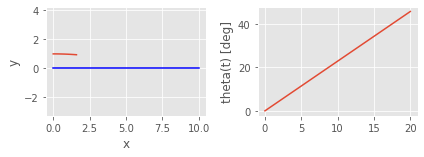

In [6]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(np.degrees(x_bar[2,:]))
plt.ylabel('theta(t) [deg]')
#plt.xlabel('time')


plt.tight_layout()
plt.show()

## State Space Linearized Model

In [2]:
"""
Control problem statement.
"""

N = 4 #number of state variables
M = 2 #number of control variables
T = 20 #Prediction Horizon
DT = 0.2 #discretization step

In [3]:
def get_linear_model(x_bar,u_bar):
    """
    Computes the LTI approximated state space model x' = Ax + Bu + C
    """
    
    L=0.3 #vehicle wheelbase
    
    x = x_bar[0]
    y = x_bar[1]
    v = x_bar[2]
    theta = x_bar[3]
    
    a = u_bar[0]
    delta = u_bar[1]
    
    A = np.zeros((N,N))
    A[0,2]=np.cos(theta)
    A[0,3]=-v*np.sin(theta)
    A[1,2]=np.sin(theta)
    A[1,3]=v*np.cos(theta)
    A[3,2]=v*np.tan(delta)/L
    A_lin=np.eye(N)+DT*A
    
    B = np.zeros((N,M))
    B[2,0]=1
    B[3,1]=v/(L*np.cos(delta)**2)
    B_lin=DT*B
    
    f_xu=np.array([v*np.cos(theta), v*np.sin(theta), a,v*np.tan(delta)/L]).reshape(N,1)
    C_lin = DT*(f_xu - np.dot(A,x_bar.reshape(N,1)) - np.dot(B,u_bar.reshape(M,1)))
    
    return np.round(A_lin,4), np.round(B_lin,4), np.round(C_lin,4)

In [7]:
%%time

u_bar = np.zeros((M,T))
u_bar[0,:] = 0.2 #m/s
u_bar[1,:] = np.radians(-np.pi/4) #rad

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = 0
x0[3] = np.radians(0)

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(N,1)
    ut=u_bar[:,t-1].reshape(M,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.dot(A,xt)+np.dot(B,ut)+C
    
    x_bar[:,t]= np.squeeze(xt_plus_one)

CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 1.82 ms


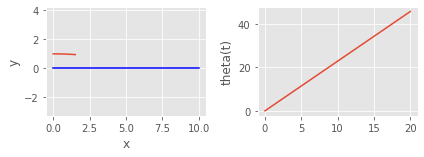

In [8]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(np.degrees(x_bar[2,:]))
plt.ylabel('theta(t)')
#plt.xlabel('time')


plt.tight_layout()
plt.show()

The results are the same as expected, so the linearized model is equivalent as expected.